### Load the MNIST and CIFAR10 Datasets
- Both datasets will be loaded from the torch.vision python package to make the import easier

In [1]:
# Load the Datasets
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.autograd import Variable

# Use GPU as the device if possible
default_device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(default_device)

cuda


In [2]:
default_batch_size = 64
image_size = 32

In [3]:
# Load MNIST
# MNIST transform to preprocess the data
transform_mnist = transforms.Compose([transforms.ToTensor(), 
                                      transforms.Normalize((0.5,),(0.5,))])

def normalize(x):
    # x = x / 255
    return x

# Download and load the training data
trainset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=True, transform=transform_mnist)
trainset_mnist.data = normalize(trainset_mnist.data)
trainloader_mnist = torch.utils.data.DataLoader(trainset_mnist, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_mnist = datasets.MNIST('./data/MNIST_data/', download=True, train=False, transform=transform_mnist)
testset_mnist.data = normalize(testset_mnist.data)
testloader_mnist = torch.utils.data.DataLoader(testset_mnist, batch_size=default_batch_size, shuffle=True)


In [92]:
# LOAD CIFAR 10
# Cifar transform to preprocess the data
transcform_cifar_norm = transforms.Normalize((0.5,0.5, 0.5),(0.5, 0.5, 0.5)).to(default_device)
transform_cifar = transforms.Compose([transforms.ToTensor(), 
                                      transcform_cifar_norm])

# Download and load the training data
trainset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=True, transform=transform_cifar)
trainloader_cifar = torch.utils.data.DataLoader(trainset_cifar, batch_size=default_batch_size, shuffle=True)

# Download and load the test data
testset_cifar = datasets.CIFAR10('./data/CIFAR10_data/', download=True, train=False, transform=transform_cifar)
testloader_cifar = torch.utils.data.DataLoader(testset_cifar, batch_size=default_batch_size, shuffle=False)


Files already downloaded and verified
Files already downloaded and verified


#VAE

In [ ]:
# VAE Model Definition
class VAE_linear(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size, dropout_rate=0.2):
        super(VAE_linear, self).__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, latent_size * 2, device=default_device))  # x2 for mean and variance

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, hidden_size, device=default_device),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, input_size, device=default_device),
            nn.Sigmoid()  # Sigmoid activation for pixel values between 0 and 1
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std, device=default_device)
        return mu + eps * std

    def forward(self, x):
        # Encode
        encoding = self.encoder(x)
        mu, log_var = torch.chunk(encoding, 2, dim=1)

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        reconstruction = self.decoder(z)

        return reconstruction, mu, log_var


class VAE_conv(nn.Module):
    def __init__(self, input_size, hidden_size, latent_size):
        super(VAE_conv, self).__init__()
        channel_size = 32

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(channel_size * 2, channel_size * 4, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(channel_size * 4 * 4 * 4, latent_size * 2)  # Adjusted for mu and log_var
        ).to(default_device)

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, channel_size * 4 * 4 * 4),
            nn.ReLU(),
            nn.Unflatten(1, (channel_size * 4, 4, 4)),
            nn.ConvTranspose2d(channel_size * 4, channel_size * 2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size * 2, channel_size, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(channel_size, 3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        ).to(default_device)

        # Latent space
        self.fc_mu = nn.Linear(hidden_size, latent_size).to(default_device)
        self.fc_log_var = nn.Linear(hidden_size, latent_size).to(default_device)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # Encode
        x = self.encoder(x)
        mu, log_var = torch.chunk(x, 2, dim=1)  # Split into mu and log_var

        # Reparameterization trick
        z = self.reparameterize(mu, log_var)

        # Decode
        x_recon = self.decoder(z)

        return x_recon, mu, log_var

# VAE Loss function
def vae_loss_function(recon_x, x, mu, log_var, input_size):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, input_size), reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return (BCE, KLD)

# VAE Training function
def train_vae_linear(model, trainloader, optimizer, num_epochs, input_size):
    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.view(-1, input_size).to(default_device)
            inputs = Variable(inputs)

            # PyTorch accumulates gradients on subsequent backward passes - so zero the grads
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
            totalloss = BCE + KLD

            # Backward pass
            totalloss.backward()

            # Update weights
            optimizer.step()

            if i % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item(), KLD.item(), totalloss.item()))

def vae_loss_function_conv(recon_x, x, mu, log_var):
    # Flatten recon_x to match the shape of x
    recon_x_flat = recon_x.view(x.size())

    BCE = nn.functional.binary_cross_entropy(recon_x_flat, x, reduction='sum')

    # KL Divergence
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())

    return (BCE, KLD)

def train_vae_conv(model, trainloader, optimizer, num_epochs, input_size):
    # Training loop
    for epoch in range(num_epochs):
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            inputs = inputs.to(default_device)

            # Zero the gradients
            optimizer.zero_grad()

            # Forward pass
            recon_batch, mu, log_var = model(inputs)

            # Reshape the inputs for the loss function
            inputs_flat = inputs.view(-1, 3, 32, 32)
            recon_batch_flat = recon_batch.view(-1, 3, 32, 32)

            # Binary cross entropy, KL divergence
            (BCE, KLD) = vae_loss_function_conv(recon_batch_flat, inputs, mu, log_var)
            loss = BCE + KLD

            # Backward pass
            loss.backward()

            # Update weights
            optimizer.step()

            if i % 500 == 0:
                print('Epoch [{}/{}], Step [{}/{}], BCE: {:.4f}, KLD: {:.4f}, Total Loss: {:.4f}'
                    .format(epoch+1, num_epochs, i+1, len(trainloader), BCE.item(), KLD.item(), loss.item()))



In [ ]:
# GAN Model Definition

In [ ]:
# WGAN Model Definition

## Train the Models - MNIST
Start training the VAE, GAN and WGAN models with the MNIST dataset.

In [ ]:
# MNIST Data Training
input_size = 28 * 28 # Size of MNIST images - 784
hidden_size = 512 # Hidden size for hidden layer
latent_size = 128 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 1 # Number of epochs to train for

# Initialize the model
vae_model_mnist = VAE_linear(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_mnist.parameters(), lr=learning_rate)

# Train the model
train_vae_linear(vae_model_mnist, trainloader_mnist, optimizer, num_epochs, input_size)


In [ ]:
# CIFAR 10 Data Training - Linear
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
hidden_size = 512 # Hidden size for hidden layer
latent_size = 512 # Latent size for latent vector
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 1 # Number of epochs to train for

# Initialize the model
vae_model_cifar_linear = VAE_linear(input_size, hidden_size, latent_size)
# Optimizer
optimizer = optim.Adam(vae_model_cifar_linear.parameters(), lr=learning_rate)

# Train the model
train_vae_linear(vae_model_cifar_linear, trainloader_cifar, optimizer, num_epochs, input_size)


In [ ]:
# CIFAR 10 Data Training - Conv
input_size = 32 * 32 * 3 # Size of CIFAR images - 3072
hidden_size = 512 # Hidden size for hidden layer ** relationship in the cnn architecture so can't just change this
latent_size = 512 # Latent size for latent vector -- trial [2, 64, 128]
learning_rate = 0.001 # Learning rate for the optimizer
num_epochs = 1 # Number of epochs to train for

# CNN

# Initialize the model
vae_model_cifar = VAE_conv(input_size, hidden_size, latent_size)

# Optimizer
optimizer = optim.Adam(vae_model_cifar.parameters(), lr=learning_rate)

# Train the model
train_vae_conv(vae_model_cifar, trainloader_cifar, optimizer, num_epochs, input_size)


## Testing Evaluation

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def vae_create_original_and_reconstructed_images_arrays(model, testloader, input_size):
    model.eval()

    # Initialize lists to store original and reconstructed images for testing
    test_original_images = []
    test_reconstructed_images = []

    # Calculate the average reconstruction loss on the testing dataset
    test_average_loss = 0.0
    test_num_batches = 0

    # Evaluate on the entire testing dataset
    with torch.no_grad():
        for data in testloader:
            inputs, _ = data
            inputs = inputs.view(-1, input_size).to(default_device)
            
            # Forward pass
            recon_batch, mu, log_var = vae_model_mnist(inputs)
            
            # Compute loss
            (BCE, KLD) = vae_loss_function(recon_batch, inputs, mu, log_var, input_size)
            loss = BCE + KLD
            test_average_loss += loss.item()
            test_num_batches += 1

            # Convert to numpy arrays for visualization
            test_original_images.append(inputs.cpu().numpy())
            test_reconstructed_images.append(recon_batch.cpu().numpy())

    # Concatenate the batches
    test_original_images = np.concatenate(test_original_images, axis=0)
    test_reconstructed_images = np.concatenate(test_reconstructed_images, axis=0)

    test_average_loss /= test_num_batches
    print('Average loss: {:.4f}'.format(test_average_loss))
    return test_original_images, test_reconstructed_images, test_average_loss

def vae_visualize_original_and_reconstructed(original_images, reconstructed_images, shape, n_samples=10):
    # Select n random images
    indices = np.random.choice(len(original_images), n_samples, replace=False)

    # Plot the original images
    fig, axes = plt.subplots(2, n_samples, figsize=(15, 4))

    for i, index in enumerate(indices):
        axes[0, i].imshow(original_images[index].reshape(shape), cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title('Original')

        axes[1, i].imshow(reconstructed_images[index].reshape(shape), cmap='gray')
        axes[1, i].axis('off')
        axes[1, i].set_title('Reconstruct')
    plt.show()


# Visualize the original and reconstructed images -- MNIST
test_original_images, test_reconstructed_images, test_average_loss = vae_create_original_and_reconstructed_images_arrays(vae_model_mnist, testloader_mnist, input_size)
vae_visualize_original_and_reconstructed(test_original_images, test_reconstructed_images, shape=(28,28))

In [ ]:
import torchvision
import torchvision.transforms as transforms

def generate_and_show_cifar(vae_model, data_loader, num_rows=5):
    vae_model.eval()

    with torch.no_grad():
        # Get a batch of real images
        real_images, _ = next(iter(data_loader))
        real_images = real_images.to(default_device)

        # Generate images using the VAE
        recon_images, _, _ = vae_model(real_images)

    # Display the images
    fig, axes = plt.subplots(num_rows, 2, figsize=(10, 2 * num_rows))
    for i in range(num_rows):
        # Display real images
        axes[i, 0].imshow(torchvision.utils.make_grid(real_images[i].cpu(), nrow=1).permute(1, 2, 0))
        axes[i, 0].axis('off')
        axes[i, 0].set_title('Real Image')

        # Display generated images
        axes[i, 1].imshow(torchvision.utils.make_grid(recon_images[i].cpu(), nrow=1).permute(1, 2, 0))
        axes[i, 1].axis('off')
        axes[i, 1].set_title('Generated Image')

    plt.show()

# Assuming your VAE model and DataLoader are already defined
generate_and_show_cifar(vae_model_cifar, testloader_cifar, num_rows=10)

In [ ]:
# Code to show the images in the training set, versus the linear images

# Function to unnormalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # Unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Function to generate and display reconstructed images from the VAE
def generate_and_show_cifar_linear(vae_model, data_loader, num_rows=1):
    vae_model.eval()
    with torch.no_grad():
        for images, _ in data_loader:
            # Display original images
            print('Original Images:')
            imshow(torchvision.utils.make_grid(images, nrow=num_rows))

            # Forward pass through the VAE
            images = images.view(-1, 3 * 32 * 32).to(default_device)
            recon_images, _, _ = vae_model(images)

            # Reshape reconstructed images for visualization
            recon_images = recon_images.view(-1, 3, 32, 32)

            # Display reconstructed images
            print('Reconstructed Images:')
            imshow(torchvision.utils.make_grid(recon_images.cpu(), nrow=num_rows))
            break  # Break after the first batch for demonstration purposes



# Compare trained and untrained images
generate_and_show_cifar_linear(vae_model_cifar_linear, testloader_cifar, num_rows=10)



# GAN - CIFAR
Train the GAN model on the CIFAR dataset, and evaluate.

In [128]:
# DC GAN
class Generator(nn.Module):
    def __init__(self, z_dim, feature_size, channels_img):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d(z_dim, feature_size * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.ReLU(True),
            # state size. ``(feature_size*8) x 4 x 4``
            nn.ConvTranspose2d(feature_size * 8, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( feature_size * 4, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( feature_size * 2, feature_size, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( feature_size, channels_img, 3, 1, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        ).to(default_device)
    
    def forward(self, input):
        return self.main(input)

class Discriminator(nn.Module):
    def __init__(self, feature_size=64, channels_img=3):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(channels_img, feature_size, 3, 1, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(feature_size, feature_size * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(feature_size * 2, feature_size * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(feature_size * 4, feature_size * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(feature_size * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(feature_size * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        ).to(default_device)

    def forward(self, input):
        return self.main(input)

In [130]:
import torchvision
import torchvision.transforms as transforms

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

# Training Loop
# Hyperparameters
z_dim = 100 # latent vector dimension
img_channels = 3
hidden_dim_feature_map = 64 # Size of the image (feature maps) at the last layer of the generator and first layer of the discriminator
lr = 0.0002
batch_size = 64
num_epochs = 15


# Create the generator and discriminator and apply the weights_init function
generator = Generator(z_dim, hidden_dim_feature_map, img_channels).to(default_device)
generator.apply(weights_init)
discriminator = Discriminator(hidden_dim_feature_map, img_channels)
discriminator.apply(weights_init)


# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, z_dim, 1, 1, device=default_device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
optimizerG = optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(trainloader_cifar, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        discriminator.zero_grad()
        # Format batch
        real_cpu = data[0].to(default_device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=default_device)
        # Forward pass real batch through D
        output = discriminator(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, z_dim, 1, 1, device=default_device)
        # Generate fake image batch with G
        fake = generator(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = discriminator(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        generator.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = discriminator(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 500 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(trainloader_cifar),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(trainloader_cifar)-1)):
            with torch.no_grad():
                fake = generator(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/15][0/782]	Loss_D: 1.9411	Loss_G: 7.2834	D(x): 0.7019	D(G(z)): 0.7134 / 0.0011
[0/15][250/782]	Loss_D: 0.1266	Loss_G: 7.4156	D(x): 0.9550	D(G(z)): 0.0704 / 0.0011
[0/15][500/782]	Loss_D: 0.3445	Loss_G: 7.9153	D(x): 0.7838	D(G(z)): 0.0061 / 0.0010
[0/15][750/782]	Loss_D: 0.6203	Loss_G: 5.1139	D(x): 0.9016	D(G(z)): 0.3136 / 0.0105
[1/15][0/782]	Loss_D: 0.3464	Loss_G: 4.0644	D(x): 0.8945	D(G(z)): 0.1687 / 0.0317
[1/15][250/782]	Loss_D: 0.4152	Loss_G: 4.7988	D(x): 0.7327	D(G(z)): 0.0249 / 0.0233
[1/15][500/782]	Loss_D: 0.7059	Loss_G: 1.7990	D(x): 0.6199	D(G(z)): 0.0602 / 0.2397
[1/15][750/782]	Loss_D: 0.5077	Loss_G: 3.3581	D(x): 0.8012	D(G(z)): 0.1920 / 0.0549
[2/15][0/782]	Loss_D: 0.3765	Loss_G: 4.4858	D(x): 0.9196	D(G(z)): 0.2231 / 0.0159
[2/15][250/782]	Loss_D: 1.2888	Loss_G: 3.0053	D(x): 0.3848	D(G(z)): 0.0077 / 0.1162
[2/15][500/782]	Loss_D: 0.4910	Loss_G: 5.1570	D(x): 0.9605	D(G(z)): 0.3167 / 0.0098
[2/15][750/782]	Loss_D: 1.0186	Loss_G: 4.5050	D(x): 0.89

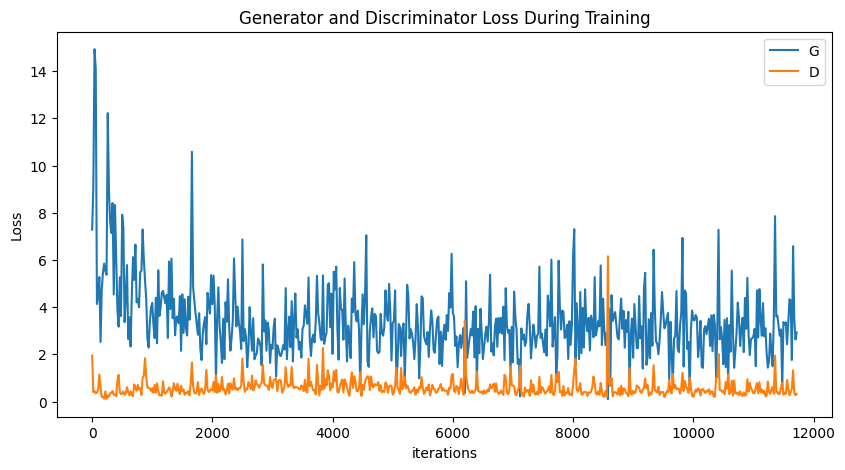

In [131]:
plot_every = 20

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(range(0, len(G_losses), plot_every), G_losses[::plot_every],label="G")
plt.plot(range(0, len(D_losses), plot_every), D_losses[::plot_every],label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

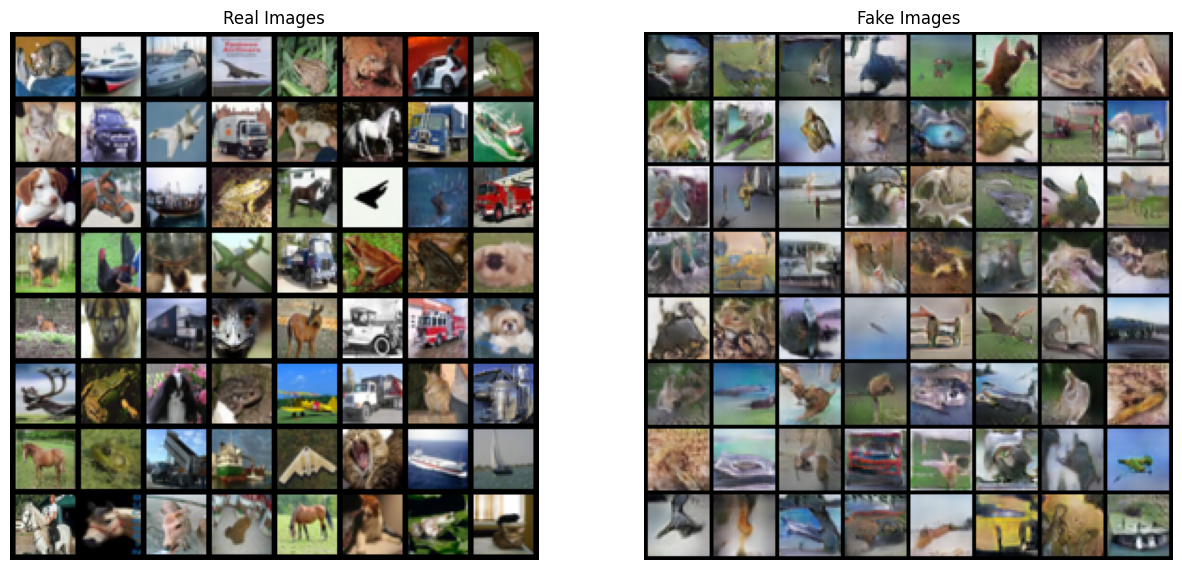

In [132]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(testloader_cifar))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(default_device)[:64], padding=3, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()